In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pyzx as zx
from extraction.focus_gflow_graph import *
from extraction.perceval import *
import perceval as pcvl
from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library.basis_change import qft

def to_graph_like(g):
    zx.spider_simp(g)
    zx.to_gh(g)
    #zx.id_simp(g)
    #zx.spider_simp(g)

In [2]:
#circuit='./circuits/grover-orig.qasm'
#circuit='./circuits/grover.qasm'
circuit='./circuits/vbe_adder_3.qasm'
circuit='QASMBench/small/toffoli_n3/toffoli_n3.qasm'
ft = qft.QFT(16)
ft = transpile(ft, basis_gates=['cx','cz','rx','rz','h'])

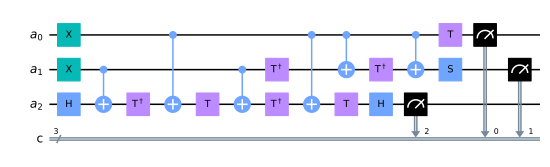

In [3]:
qc = QuantumCircuit.from_qasm_file(circuit)
qc.draw(output='mpl', scale=0.75)

In [4]:
c = zx.Circuit.load(circuit)
#c = zx.Circuit.from_qasm(ft.qasm())
g = c.to_graph()
zx.draw(g)

In [ ]:
to_graph_like(g)
g2 = g.copy()
zx.simplify.clifford_simp(g2)
zx.full_reduce(g2)
#g2.normalize()
g2 = g2.copy()
zx.draw(zx.Graph.from_json(g2.to_json()), labels=True)

In [ ]:
p = PercevalExtraction(g2.to_json())
p.extract_clusters_from_graph_ghz_first()
print("GHZ-Clusters")
print(p.ghz_clusters_dict)
print("Lin Clusters")
print(p.lin_clusters_dict)
exp,cluster = p.create_setup(True, True)
pcvl.pdisplay(exp)
#print("Components: " + str(exp.ncomponents()))
#print("Photons: " + str(exp.m))

# Visualisation

In [ ]:
from ipywidgets import widgets
from IPython.display import display, Markdown

from pyzx.simplify import clifford_iter

graph = c.to_graph()
graphs = [zx.draw_matplotlib(graph)]
names = ["start"]
for gs, n in clifford_iter(graph):
    graphs.append(zx.draw_matplotlib(gs))
    names.append(n)
zx.drawing.pack_circuit_nf(gs,'grg')
graphs.append(zx.draw_matplotlib(gs))
names.append("reposition")

def plotter(rewrite):
    display(Markdown("Rewrite step: " + names[rewrite]))
    display(graphs[rewrite])

w = widgets.interactive(plotter, rewrite=(0,len(graphs)-1))
slider = w.children[0]
slider.layout.width = "{!s}px".format(min(800,50*len(graphs)))
output = w.children[-1]
output.layout.height = "{!s}px".format(200+graph.qubit_count()*20)
slider.value = 0
w

# Stuff

In [11]:
import numpy as np
100 < np.inf

True

In [ ]:
fg_graph = build_focused_gflow_graph(g, focus_gflow(g, gflow(g)))
zx.draw(fg_graph, labels=True)

In [ ]:
p = PercevalExtraction(g.to_json())

In [ ]:
g2 = g.copy()
fg_graph = build_focused_gflow_graph(g2, focus_gflow(g2, gflow(g2)))
list(fg_graph.neighbors(20))[0]
20 not in fg_graph.inputs()
fg_graph.outputs()
max(fg_graph.vertices())

In [ ]:
g2 = g.copy()
fg_graph = build_focused_gflow_graph(g2, focus_gflow(g2, gflow(g2)))
w_graph = g2.copy()
i = 0
neighbors_list = []
lin_clusters = {}
ghz_clusters = {}
fusions={}
zx.draw(w_graph,labels=True)        

#remove edges from inputs and outputs
for v in w_graph.inputs() + w_graph.outputs():
    w_graph.remove_edge(w_graph.edge(v,list(w_graph.neighbors(v))[0]))

#prepare a list sorted by number of neighbors to get the largest GHZ-Clusters first
for v in w_graph.vertices():
    if v not in w_graph.inputs() and v not in w_graph.outputs() and len(w_graph.neighbors(v)) > 2:
        neighbors_list.append((v,len(w_graph.neighbors(v))))

        
#Find GHZ-Clusters in the Graph und remove their edges from the Graph
for (v,l) in sorted(neighbors_list, key=lambda tup: tup[1], reverse=True):
    if v not in w_graph.inputs() and v not in w_graph.outputs() and len(w_graph.neighbors(v)) > 2:
        ghz_clusters[v] = [v]
        while len(w_graph.neighbors(v)) > 0:
            n = list(w_graph.neighbors(v))[0]
            if n not in w_graph.outputs() and n not in w_graph.inputs():
                ghz_clusters[v].append(n)
            w_graph.remove_edge(w_graph.edge(v,n))
zx.draw(w_graph,labels=True)

print("Now the linear clusters")
    
#Find Lin-Clusters in the remaining Graph und remove their edges from the Graph.
for v in list(w_graph.vertices()):
    if len(w_graph.neighbors(v)) == 1:
        n = v
        lin_clusters[v] = [n]
        while len(w_graph.neighbors(n))> 0:
            n2 = list(w_graph.neighbors(n))[0]
            lin_clusters[v].append(n2)
            w_graph.remove_edge(w_graph.edge(n,n2))
            n = n2
zx.draw(w_graph,labels=True)        
            
# There should be no edges left in the Graph....
if (w_graph.num_edges() == 0):
    print("Everything worked out fine, no edges = " + str(w_graph.num_edges()))

for k,v in ghz_clusters.items():
    for k2,v2 in ghz_clusters.items():
        if k==k2: 
            continue
        for i in v:
            if i in v2:
                if i not in fusions.keys():
                    fusions[i] = []    
                fusions[i].append(k)    
                fusions[i].append(k2)
    
    for k2,v2 in lin_clusters.items():
        if k==k2: 
            continue
        for i in v:
            if i in v2:
                if i not in fusions.keys():
                    fusions[i] = []    
                fusions[i].append(k)    
                fusions[i].append(k2)
for k,v in fusions.items():
    fusions[k] = list(set(v))

#print(g2.num_vertices(), g2.num_edges())
#print(sorted(neighbors_list, key=lambda tup: tup[1], reverse=True))
print(ghz_clusters)
print(lin_clusters)
print(fusions)

In [ ]:
g2 = g.copy()
fg_graph = build_focused_gflow_graph(g2, focus_gflow(g2, gflow(g2)))
w_graph = g2.copy()
zx.draw(fg_graph)
i = 0
lin_clusters = {}
ghz_clusters = {}

for v in w_graph.vertices():
    if v not in w_graph.inputs() and v not in w_graph.outputs() and len(w_graph.neighbors(v)) > 2:
        neighbors_list.append((v,len(w_graph.neighbors(v))))
    
for (v,l) in sorted(neighbors_list, key=lambda tup: tup[1], reverse=True):
    if v not in w_graph.inputs() and v not in w_graph.outputs() and len(w_graph.neighbors(v)) > 2:
        ghz_clusters[v] = []
        while len(w_graph.neighbors(v)) > 0:
            n = list(w_graph.neighbors(v))[0]
            if n not in w_graph.outputs() and n not in w_graph.inputs():
                ghz_clusters[v].append(n)
            w_graph.remove_edge(w_graph.edge(v,n))

for v in list(w_graph.edges()):
    if w_graph.neighbors(v) == 1:
        n = v
        lin_clusters[v] = [n]
        while w_graph.neighbors(n)> 0:
            n2 = list(wg_graph.neighbors(n))[0]
            lin_clusters[v].append(n2)
            w_graph.remove_edge(w_graph.edge(n,n2))
            n = n2
            
            
while len(list(w_graph.edges()))>0:
    n = max(fg_graph.vertices())
    lin_clusters[i] = [n]
    while n not in fg_graph.inputs() and len(fg_graph.neighbors(n))>0:
        neigh = list(fg_graph.neighbors(n))[0]
        lin_clusters[i].insert(0,neigh)
        fg_graph.remove_edge(fg_graph.edge(n,neigh))
        if len(fg_graph.neighbors(n)) == 0:
            fg_graph.remove_vertex(n)
        n = neigh
    if len(fg_graph.neighbors(n)) == 0:
            fg_graph.remove_vertex(n)
    i=i+1
    zx.draw(fg_graph)
vertical_fusions = []
qubit_fusions = []
for key in lin_clusters.keys():
    for node in lin_clusters[key]:
        for key2 in lin_clusters.keys():
            if key2 > key:
                for node2 in lin_clusters[key2]:
                    if g.connected(node,node2):
                        vertical_fusions.append([(key,node),(key2,node2)])
                if node in lin_clusters[key2]:
                    qubit_fusions.append([(key,node), (key2,node)])
lin_clusters

In [ ]:
g2 = g.copy()
fg_graph = build_focused_gflow_graph(g2, focus_gflow(g2, gflow(g2)))
w_graph = g2.copy()
i = 0
neighbors_list = []
lin_clusters = {}
ghz_clusters = {}
fusions={}
zx.draw(w_graph,labels=True)        

#remove edges from inputs and outputs
for v in w_graph.inputs() + w_graph.outputs():
    w_graph.remove_edge(w_graph.edge(v,list(w_graph.neighbors(v))[0]))

#prepare a list sorted by number of neighbors to get the largest GHZ-Clusters first
for v in w_graph.vertices():
    if v not in w_graph.inputs() and v not in w_graph.outputs() and len(w_graph.neighbors(v)) > 2:
        neighbors_list.append((v,len(w_graph.neighbors(v))))

        
#Find GHZ-Clusters in the Graph und remove their edges from the Graph
for (v,l) in sorted(neighbors_list, key=lambda tup: tup[1], reverse=True):
    if v not in w_graph.inputs() and v not in w_graph.outputs() and len(w_graph.neighbors(v)) > 2:
        ghz_clusters[v] = [v]
        while len(w_graph.neighbors(v)) > 0:
            n = list(w_graph.neighbors(v))[0]
            if n not in w_graph.outputs() and n not in w_graph.inputs():
                ghz_clusters[v].append(n)
            w_graph.remove_edge(w_graph.edge(v,n))
zx.draw(w_graph,labels=True)

print("Now the linear clusters")
    
#Find Lin-Clusters in the remaining Graph und remove their edges from the Graph.
for v in list(w_graph.vertices()):
    if len(w_graph.neighbors(v)) == 1:
        n = v
        lin_clusters[v] = [n]
        while len(w_graph.neighbors(n))> 0:
            n2 = list(w_graph.neighbors(n))[0]
            lin_clusters[v].append(n2)
            w_graph.remove_edge(w_graph.edge(n,n2))
            n = n2
zx.draw(w_graph,labels=True)        
            
# There should be no edges left in the Graph....
if (w_graph.num_edges() == 0):
    print("Everything worked out fine, no edges = " + str(w_graph.num_edges()))

for k,v in ghz_clusters.items():
    for k2,v2 in ghz_clusters.items():
        if k==k2: 
            continue
        for i in v:
            if i in v2:
                if i not in fusions.keys():
                    fusions[i] = []    
                fusions[i].append(k)    
                fusions[i].append(k2)
    
    for k2,v2 in lin_clusters.items():
        if k==k2: 
            continue
        for i in v:
            if i in v2:
                if i not in fusions.keys():
                    fusions[i] = []    
                fusions[i].append(k)    
                fusions[i].append(k2)
for k,v in fusions.items():
    fusions[k] = list(set(v))

#print(g2.num_vertices(), g2.num_edges())
#print(sorted(neighbors_list, key=lambda tup: tup[1], reverse=True))
print(ghz_clusters)
print(lin_clusters)
print(fusions)

In [ ]:
g2 = g.copy()
fg_graph = build_focused_gflow_graph(g2, focus_gflow(g2, gflow(g2)))
w_graph = g2.copy()
zx.draw(fg_graph)
i = 0
lin_clusters = {}
ghz_clusters = {}

for v in w_graph.vertices():
    if v not in w_graph.inputs() and v not in w_graph.outputs() and len(w_graph.neighbors(v)) > 2:
        neighbors_list.append((v,len(w_graph.neighbors(v))))
    
for (v,l) in sorted(neighbors_list, key=lambda tup: tup[1], reverse=True):
    if v not in w_graph.inputs() and v not in w_graph.outputs() and len(w_graph.neighbors(v)) > 2:
        ghz_clusters[v] = []
        while len(w_graph.neighbors(v)) > 0:
            n = list(w_graph.neighbors(v))[0]
            if n not in w_graph.outputs() and n not in w_graph.inputs():
                ghz_clusters[v].append(n)
            w_graph.remove_edge(w_graph.edge(v,n))

for v in list(w_graph.edges()):
    if w_graph.neighbors(v) == 1:
        n = v
        lin_clusters[v] = [n]
        while w_graph.neighbors(n)> 0:
            n2 = list(wg_graph.neighbors(n))[0]
            lin_clusters[v].append(n2)
            w_graph.remove_edge(w_graph.edge(n,n2))
            n = n2
            
            
while len(list(w_graph.edges()))>0:
    n = max(fg_graph.vertices())
    lin_clusters[i] = [n]
    while n not in fg_graph.inputs() and len(fg_graph.neighbors(n))>0:
        neigh = list(fg_graph.neighbors(n))[0]
        lin_clusters[i].insert(0,neigh)
        fg_graph.remove_edge(fg_graph.edge(n,neigh))
        if len(fg_graph.neighbors(n)) == 0:
            fg_graph.remove_vertex(n)
        n = neigh
    if len(fg_graph.neighbors(n)) == 0:
            fg_graph.remove_vertex(n)
    i=i+1
    zx.draw(fg_graph)
vertical_fusions = []
qubit_fusions = []
for key in lin_clusters.keys():
    for node in lin_clusters[key]:
        for key2 in lin_clusters.keys():
            if key2 > key:
                for node2 in lin_clusters[key2]:
                    if g.connected(node,node2):
                        vertical_fusions.append([(key,node),(key2,node2)])
                if node in lin_clusters[key2]:
                    qubit_fusions.append([(key,node), (key2,node)])
lin_clusters

In [ ]:
qubits = iter(g.qubits().values())

In [ ]:
import numpy as np
from itertools import chain

lin_clusters = dict([(v, [k for k, v1 in g.qubits().items() if v1 == v])
              for v in set(g.qubits().values())])

qubits = set(g.qubits().values())
fusions = []
for key in lin_clusters.keys():
    for node in lin_clusters[key]:
        for key2 in lin_clusters.keys():
            if key2 > key:
                for node2 in lin_clusters[key2]:
                    if g.connected(node,node2):
                        fusions.append([node,node2])

print(fusions)
print(lin_clusters.items())

In [ ]:
qubits = iter(g.qubits().values())

In [ ]:
import numpy as np
from itertools import chain

lin_clusters = dict([(v, [k for k, v1 in g.qubits().items() if v1 == v])
              for v in set(g.qubits().values())])

qubits = set(g.qubits().values())
fusions = []
for key in lin_clusters.keys():
    for node in lin_clusters[key]:
        for key2 in lin_clusters.keys():
            if key2 > key:
                for node2 in lin_clusters[key2]:
                    if g.connected(node,node2):
                        fusions.append([node,node2])

print(fusions)
print(lin_clusters.items())

In [ ]:
g1 = g.copy()
print(g.outputs())
zx.simplify.full_reduce(g1)
g1.normalize()
zx.draw(g1, labels=True)

# Hier kommt das Cluster Zeug

In [ ]:
g_new = zx.Graph()
zx.editor.edit(g_new)

In [ ]:
g_new.normalize()
zx.draw(g_new, labels=True)

In [ ]:
g1 = g_new.copy()
print(g_new.outputs())
zx.simplify.full_reduce(g1)
g1.normalize()
zx.draw(g1, labels=True)

In [ ]:
c2 = zx.extract_circuit(g1.copy())
g3 = c2.to_graph()
zx.draw(g3)

In [ ]:
c2 = zx.extract_circuit(g1.copy())
g3 = c2.to_graph()
zx.draw(g3)

In [ ]:
c1 = zx.extract_circuit(g1.copy())
g2 = c1.to_graph()
zx.draw(g2)